# FFT/Linear Regression Nuisance Correction

*created by Eric Bridgeford*

## Task

In an experimental setting, a number of nuisance variables can hamper the effectiveness of resting state fMRI. Variables such as motion, scanner noise, physiological drift, and a number of other factors, referred to as "nuisance" variables, can singificantly deteriorate the quality of downstream inferences that researchers are able to make. 

Our data observations at a given timestep can be described as follows:

\begin{align*}
    T_{observed} = L + Q + P + \epsilon
\end{align*}

Where the observed signal $T \in \mathbb{R}^{t \times n}$ contains the desired latent neurological signal $L \in \mathbb{R}^{t \times n}$, as well as permutations from $Q \in \mathbb{R}^{t \times n}$, a quadratic drift term produced by the scanner, $P \in \mathbb{R}^{t \times n}$, a low frequency periodic drift, and $\epsilon \in \mathbb{R}^{t \times n}$, an error term that is a result of noise that we cannot account for.

## Loss function

Here, we will make use of the sum of squared residuals (SSR) loss function. We note that our timeseries $T_{ldr}$ (low-frequency drift-removed; that is, our timeseries after removing low-frequency drift) can be modeled as:

\begin{align*}
    T_{ldr} = L + Q + \epsilon
\end{align*}

where we assume that our quadratic $Q$ is the product between $X \in \mathbb{R}^{t \times 3}$ our quadratic function and $w \in \mathbb{R}^3$ the coeffients of our quadratic, such that:

\begin{align*}
    Q = Xw \\
    Q = \begin{bmatrix}
        1 & 1 & 1 \\
        1 & 2 & 4 \\
        1 & 3 & 9 \\
        \vdots & \vdots & \vdots \\
        1 & t & t^2
    \end{bmatrix} \begin{bmatrix}
    w_0 \\ w_1 \\ w_2
    \end{bmatrix}
\end{align*}

We assume that our error $\epsilon$ is minimal, and rewrite our timeseries $T_{ldr}$:

\begin{align*}
    T_{ldr} = L + Xw \\
    L = T_{ldr} - Xw
\end{align*}

Assuming that we want to fit our data maximally (and thereby remove the best-fit quadratic, which is a simple enough model that it will not regress signal explicitly), we can use SSR:

\begin{align*}
    L(w | X, T_{ldr}) = ||L||_2^2 = ||T_{ldr} - Xw||_2^2
\end{align*}

Where we will penalize points that are not effectively fit by our model significantly due to squaring the error.

## Statistical Goal

To estimate our quadratic drift, we want to find the coefficients for a quadratic function such that:

\begin{align*}
    W = \textrm{argmin}_W L(w | X, T)
\end{align*}

Where $X \in \mathbb{R}^{t \times 3}$ is a quadratic function defined from $1:t$ with 3 coefficients; that is, a constant drift, linear drift, and quadratic drift. An example of $X$ is shown above.

Our FFT does not have a statistical goal. 

## Desiderata

With this algorithm, we have several critical desiderata that we are concerned with:

+ We want an algorithm that effectively models the nuisance variables in our timeseries
+ We want an algorithm that, unlike component correction, avoids removing task-dependent stimulus
+ We want an algorithm that will perform quickly under experimental settings, as fMRI processing is not cheap.

# Approach

## Algorithm

### High Level Description

With this algorithm, we begin by removing physiological-related low frequency drift. This can be due to a number of factors, such as physiological effects, scanner effects, and a number of other factors. We use the FFT to estimate the fourier components of our signal, remove signal that is well below the frequency range of actual brain response (signal under 0.01 Hz in particular), and then perform an inverse FFT to bring us back to the time domain. After correcting out low frequency drift, we model our resulting timeseries with a quadratic, estimate our quadratic coefficients with Least-Squares Regression, and finally remove our quadratic function from our data. In the process, this also mean-normalizes our data, which provides a favorable common axis for downstream inferences (our timeseries otherwise would be all over the place). We then replace and return our resulting nuisance corrected fMRI timeseries. 

### Pseudocode

[Pseudo](https://neurodatadesign.github.io/fngs/reveal/pdfs/fft_pseudo.pdf)

## Evaluation

### Simulation Performance

To evaluate our new FFT code, we will generate examples from various combinations of sinusoids, with one goal sinusoid corrupted with various low-frequency sinusoids, and demonstrate that we are able to recover our original signal after passing low-frequency signal. Then, we will generate an example from a quadratic with a periodic function, and show that we are able to recover our periodic stimulus. We will evaluate our simulations with qualitative comparisons before and after correction, as well as $R^2$ values between the actual signal and the uncorrected vs corrected signal. Finally, we will construct a simulation combining a quadratic with various low frequency sinusoids and one goal sinusoid, and verify that we are able to recover our goal sinusoid after correction.

### Real Data Performance

Real data will be analyzed using the discriminability.

## Simulations

### Positive Illustrative Example

#### Frequency Filtering Check

First, we will demonstrate a positive example of our frequency filtering code. We will construct one "stimulus" sinusoid (approximately 3 Hz), and permute it with several low-frequency sinusoids below the cutoff point that our real data would have (less than 0.01 Hz). 

filtering below 0.01 Hz...
Applying Frequency Filtering...


/home/eric/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:32: ComplexWarning:

Casting complex values to real discards the imaginary part



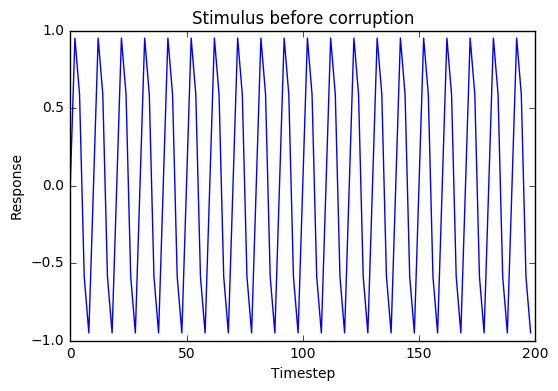

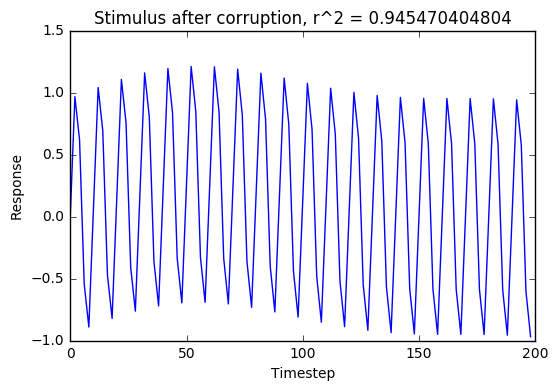

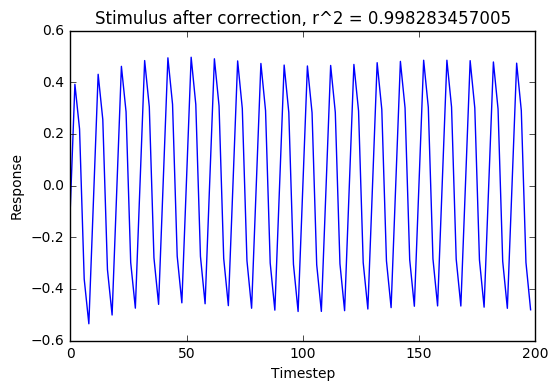

In [11]:
%matplotlib inline
import numpy as np
import ndmg.nuis.nuis as ndn  # nuisance correction scripts
import matplotlib.pyplot as plt
import nibabel as nb
import scipy.fftpack as scifft
from sklearn.metrics import r2_score

L = 200
tr = 2  # the tr of our data
t = np.linspace(0, L-1, L)  # generate time steps
stim_freq = .1

stim = np.sin(2*np.pi*stim_freq*t*tr)  # generate our stimulus timeseries

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], stim[0:100])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus before corruption')

low_freq = [0.003,0.006]
low_freq_amp = [.2,.1]
sig = stim.copy()

# add low-frequency drift
for freq, amp in zip(low_freq, low_freq_amp):
    sig += amp*np.sin(2*np.pi*freq*t*tr)

# so that we can use our fft code on it, we need an ndarray not 
# a 1d array
sig = np.expand_dims(sig, axis=1)

bef_r2 = r2_score(stim, sig[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], sig[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after corruption, r^2 = ' + str(bef_r2))


corr = ndn().freq_filter(sig, tr)

aft_r2 = r2_score(stim, corr[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], corr[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after correction, r^2 = ' + str(aft_r2))

As we can see, we are able to do a good job of removing the noise, as our $R^2$ increases from around .9 to approximately .999, which indicates that our resulting signal very significantly resembles our actual signal.

#### Quadratic Drift Removal Check

Next, we will double check the effectiveness of our ability to remove quadratic drift with our linear regression model. We will have the same stimulus sinusoid as before, and we will produce quadratic drift coefficients to simulate quadratic drifting.

In [ ]:
%matplotlib inline
import numpy as np
import ndmg.nuis.nuis as ndn  # nuisance correction scripts
import matplotlib.pyplot as plt
import nibabel as nb
import scipy.fftpack as scifft
from sklearn.metrics import r2_score

L = 200
tr = 2  # the tr of our data
t = np.linspace(0, L-1, L)  # generate time steps
stim_freq = .1

stim = np.sin(2*np.pi*stim_freq*t*tr)  # generate our stimulus timeseries

# generate coefficients for linear model
w = np.array([.75, -.01, .00005])
w = np.expand_dims(w, 1)

const = np.ones((L,1))
lin = np.array(range(0, L))
quad = np.array(range(0, L))**2

# make a design matrix
R = np.column_stack((const, lin, quad))

sig = stim.copy()
sig = np.expand_dims(sig, 1)
sig += R.dot(w)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], stim[0:100])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus before corruption')

bef_r2 = r2_score(stim, sig[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], sig[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after corruption, r^2 = ' + str(bef_r2))

corr = ndn().linear_reg(sig)

aft_r2 = r2_score(stim, corr[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], corr[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after correction, r^2 = ' + str(aft_r2))

Again, we can see that we are able to virtually perfectly fit the predicted response, as we increase our $R^2$ from .68 to .999.

#### Combined Check

Next, we will do a combined check using the same data from the previous two tests to verify that when we perform fft followed by quadratic detrending, we are again able to recover the expected sinusoid with similar accuracy.

In [ ]:
%matplotlib inline
import numpy as np
import ndmg.nuis.nuis as ndn  # nuisance correction scripts
import matplotlib.pyplot as plt
import nibabel as nb
import scipy.fftpack as scifft
from sklearn.metrics import r2_score

L = 200
tr = 2  # the tr of our data
t = np.linspace(0, L-1, L)  # generate time steps
stim_freq = .1

stim = np.sin(2*np.pi*stim_freq*t*tr)  # generate our stimulus timeseries


# generate coefficients for linear model
w = np.array([.75, -.01, .00005])
w = np.expand_dims(w, 1)

const = np.ones((L,1))
lin = np.array(range(0, L))
quad = np.array(range(0, L))**2

# make a design matrix
R = np.column_stack((const, lin, quad))

sig = stim.copy()
sig = np.expand_dims(sig, 1)
sig += R.dot(w)


low_freq = [0.003,0.006]
low_freq_amp = [.2,.1]

# add low-frequency drift
for freq, amp in zip(low_freq, low_freq_amp):
    sig += np.expand_dims(amp*np.sin(2*np.pi*freq*t*tr), 1)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], stim[0:100])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus before corruption')

bef_r2 = r2_score(stim, sig[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], sig[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after corruption, r^2 = ' + str(bef_r2))

corr = ndn().freq_filter(sig, tr, 0.01)
corr = ndn().linear_reg(sig)

aft_r2 = r2_score(stim, corr[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], corr[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after correction, r^2 = ' + str(aft_r2))

As we can see, the signal picked up dips initially, but recovers to approximately the value of the signal by the time we have a few timesteps. This shows a weakness of highpass filtering, which is its difficulty passing signal that impacts the endpoints properly.

### Negative Illustrative Example

The highpass filter will struggle when the frequencies are right near our cutoff in particular; if the cutoff is well beyond our frequency, if FFT mis-bins particular signals it has a significant margin for error. However, if we have a signal right near the cutoff and we mis-bin, we will risk binning stimulus-related sinusoids above our cutoff and not having the sitmulus removed. We demonstatrate this below:

filtering below 0.01 Hz...
Applying Frequency Filtering...
Calculating Regressors...
filtering below 0.01 Hz...
Applying Frequency Filtering...


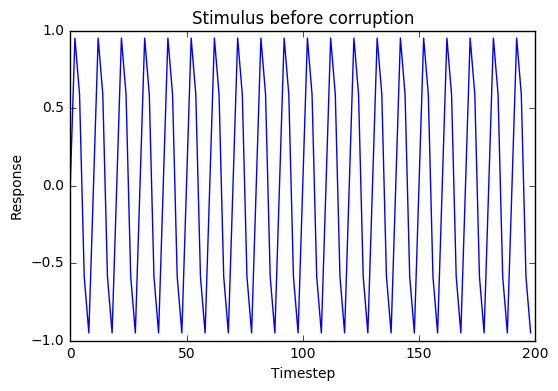

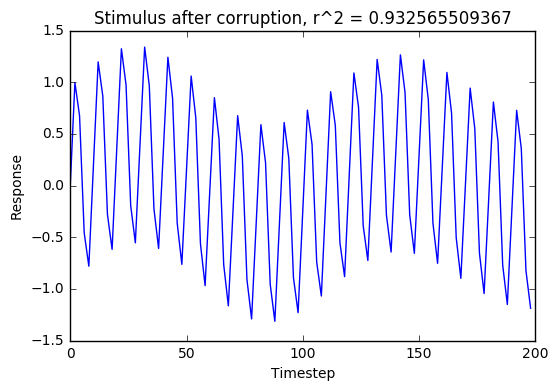

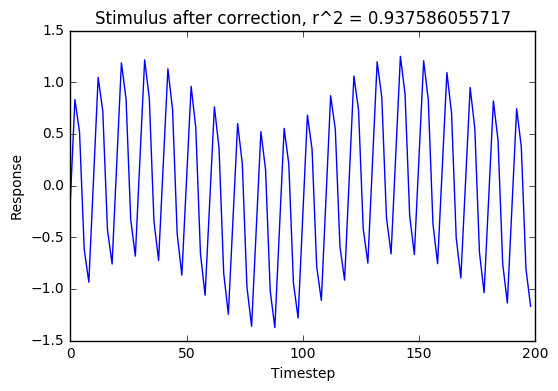

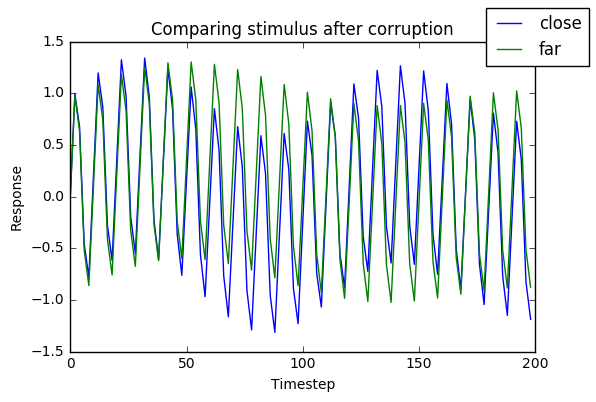

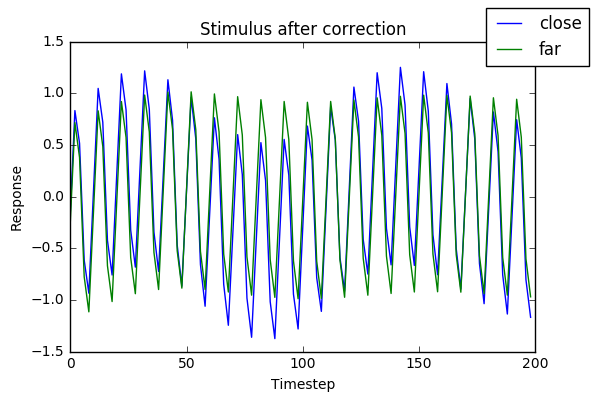

In [23]:
%matplotlib inline
import numpy as np
import ndmg.nuis.nuis as ndn  # nuisance correction scripts
import matplotlib.pyplot as plt
import nibabel as nb
import scipy.fftpack as scifft
from sklearn.metrics import r2_score

L = 200
tr = 2  # the tr of our data
t = np.linspace(0, L-1, L)  # generate time steps
stim_freq = .1

stim = np.sin(2*np.pi*stim_freq*t*tr)  # generate our stimulus timeseries

low_freq = [.0095, .008]
low_freq_amp = [.2, .2]
sig = stim.copy()
sig = np.expand_dims(sig, 1)

# add low-frequency drift
for freq, amp in zip(low_freq, low_freq_amp):
    sig += np.expand_dims(amp*np.sin(2*np.pi*freq*t*tr), 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], stim[0:100])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus before corruption')

bef_r2 = r2_score(stim, sig[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], sig[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after corruption, r^2 = ' + str(bef_r2))

corr = ndn().freq_filter(sig, tr, 0.01)
corr = ndn().linear_reg(sig)

aft_r2 = r2_score(stim, corr[:,0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((t*tr)[0:100], corr[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after correction, r^2 = ' + str(aft_r2))


low_freq2 = [0.003,0.006]
low_freq_amp2 = [.2,.2]
sig2 = stim.copy()

# add low-frequency drift
for freq, amp in zip(low_freq2, low_freq_amp2):
    sig2 += amp*np.sin(2*np.pi*freq*t*tr)

# so that we can use our fft code on it, we need an ndarray not 
# a 1d array
sig2 = np.expand_dims(sig2, axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
l1, = ax.plot((t*tr)[0:100], sig[0:100,0])
l2, = ax.plot((t*tr)[0:100], sig2[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Comparing stimulus after corruption')
fig.legend((l1, l2), ('close', 'far'))


corr2 = ndn().freq_filter(sig2, tr)

fig = plt.figure()
ax = fig.add_subplot(111)
l1, = ax.plot((t*tr)[0:100], corr[0:100,0])
l2, = ax.plot((t*tr)[0:100], 2*corr2[0:100,0])
ax.set_xlabel('Timestep')
ax.set_ylabel('Response')
ax.set_title('Stimulus after correction')
fig.legend((l1, l2), ('close', 'far'))

As we can see, our ability to recover the initial signal has deteriorated significantly from our first trial (note that our frequency bins changed from $.04$ and $0.6$ to $.095$ and $0.08$ with no change in amplitude, yet our $R^2$ dropped from $0.99$ to $0.93$. Also, the stimulus visually looked improved in the first trial, yet it looks considerably worse here. 